In [1]:
import pybammeis
import pybamm
import numpy as np
import time as timer
import matplotlib.pyplot as plt
from scipy.fft import fft



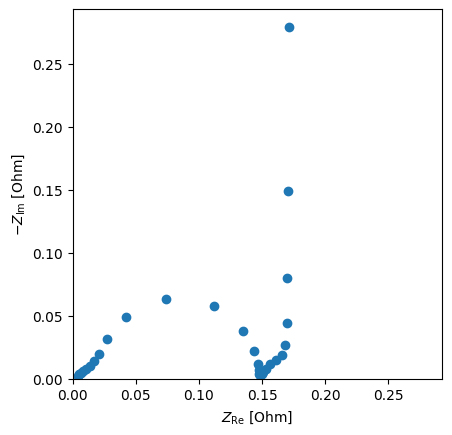

<Axes: xlabel='$Z_\\mathrm{Re}$ [Ohm]', ylabel='$-Z_\\mathrm{Im}$ [Ohm]'>

In [2]:

# DFN with capacitance
model = pybamm.lithium_ion.DFN(options={"surface form": "differential"})
eis_sim = pybammeis.EISSimulation(model)
# calculate impedance at log-spaced frequencies
eis_sim.solve(np.logspace(-4, 4, 30))

eis_sim.nyquist_plot()

Pybamm-eis functions 

Numerical methods (iterative numerical method):
- autofunction: pybammeis.bicgstab 
- autofunction: pybammeis.prebicgstab 

Plotting: 
- autofunction: pybammeeis.nyquist_plot

Simulation: 
- autoclass: pybammeis.EISSimulation

Utilities: 
- autoclass: pybammeis.SymbolReplacer

Compare methods

Time domain method:  39.98534917831421 s
Frequency domain (direct):  0.4390740394592285 s
Frequency domain (bicgstab):  0.35686612129211426 s
Frequency domain (prebicgstab):  0.32221388816833496 s


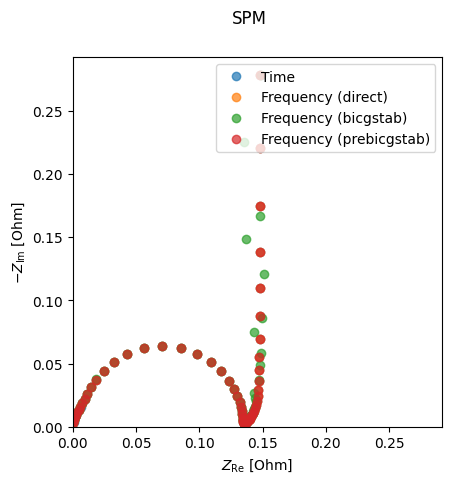

In [3]:

# Set up
model = pybamm.lithium_ion.SPM(options={"surface form": "differential"}, name="SPM")
parameter_values = pybamm.ParameterValues("Marquis2019")
frequencies = np.logspace(-4, 3, 70)
# Ser ut som man kan putte inn parametre

# Time domain
I_app = 5e-3
number_of_periods = 10
samples_per_period = 56
# Ser ut som man kan putte inn number of periods og samples per period også
# Ann_Mari snakket om at jeg bare trengte én periode og 50 samples per periode. 


def current_function(t):
    return I_app * pybamm.sin(2 * np.pi * pybamm.InputParameter("Frequency [Hz]") * t)


parameter_values["Current function [A]"] = current_function
# Oppdaterer parametrene til å ha en current function!! 

start_time = timer.time()

sim = pybamm.Simulation(
    model, parameter_values=parameter_values, solver=pybamm.ScipySolver(atol=1e-12)
)
# Så simuleringen avhenger av modellen, parametermodellen, osv. 

impedances_time = []
for frequency in frequencies:
    # Solve
    period = 1 / frequency
    dt = period / samples_per_period
    t_eval = np.array(range(0, samples_per_period * number_of_periods)) * dt
    sol = sim.solve(t_eval, inputs={"Frequency [Hz]": frequency})
    # Extract final two periods of the solution
    time = sol["Time [s]"].entries[-5 * samples_per_period :]
    current = sol["Current [A]"].entries[-5 * samples_per_period :]
    voltage = sol["Voltage [V]"].entries[-5 * samples_per_period :]
    # Vet ikke hvorfor man starter listene så langt bak? 
    # FFT - Fourier transform av current og voltage! 
    current_fft = fft(current)
    voltage_fft = fft(voltage)
    # Get index of first harmonic - the fundamental frequency itself (representing the primary sine wave)
    # Higher harmonics are multiples of this base frequency and contribute to the overall wave shape. 
    # Since they only find the first harmonic - are they assuming that the response is pseudo-linear? 
    idx = np.argmax(np.abs(current_fft))
    impedance = -voltage_fft[idx] / current_fft[idx]
    impedances_time.append(impedance)

end_time = timer.time()
time_elapsed = end_time - start_time
print("Time domain method: ", time_elapsed, "s")

# Frequency domain
methods = ["direct", "bicgstab", "prebicgstab"]
impedances_freqs = []
for method in methods:
    start_time = timer.time()
    eis_sim = pybammeis.EISSimulation(model, parameter_values=parameter_values)
    impedances_freq = eis_sim.solve(frequencies, method)
    # Du kan velge hvilken metode man kan bruke for å løse EIS. 
    end_time = timer.time()
    time_elapsed = end_time - start_time
    print(f"Frequency domain ({method}): ", time_elapsed, "s")
    impedances_freqs.append(impedances_freq)

# Compare
_, ax = plt.subplots()
ax = pybammeis.nyquist_plot(impedances_time, ax=ax, label="Time", alpha=0.7)
for i, method in enumerate(methods):
    ax = pybammeis.nyquist_plot(
        impedances_freqs[i], ax=ax, label=f"Frequency ({method})", alpha=0.7
    )

ax.legend()
plt.suptitle(f"{model.name}")
plt.show()

Time and Frequency Domains and Transforms 

Under the subtitle "Time and Frequency Domains and Transforms" in the article "Basics of EIS" there is information about the two different domains: 
- Usually, the lower frequency data are measured in the time domain: 
- digital-to-analog converter applies a sinus curve --> current response is measured by a analog-to-digital converter --> FFT is used to convert the current signal into the frequency domain. 

- In this code, you can compute directly in the frequency domain, using 3 different methods: direct, bicgstab or prebicgstab numerical methods (the difference is direct or iterative methods). 


Compare models

Start calculating impedance for SPM
Finished calculating impedance for SPM
Number of states:  46 Set-up time:  258.858 ms Solve time:  41.218 ms
Start calculating impedance for SPMe
Finished calculating impedance for SPMe
Number of states:  106 Set-up time:  563.114 ms Solve time:  179.838 ms
Start calculating impedance for DFN
Finished calculating impedance for DFN
Number of states:  904 Set-up time:  579.063 ms Solve time:  243.372 ms
Start calculating impedance for SPM (pouch)
Finished calculating impedance for SPM (pouch)
Number of states:  4404 Set-up time:  646.310 ms Solve time:  464.971 ms
Start calculating impedance for DFN (pouch)
Finished calculating impedance for DFN (pouch)
Number of states:  45204 Set-up time:  4.319 s Solve time:  8.796 s


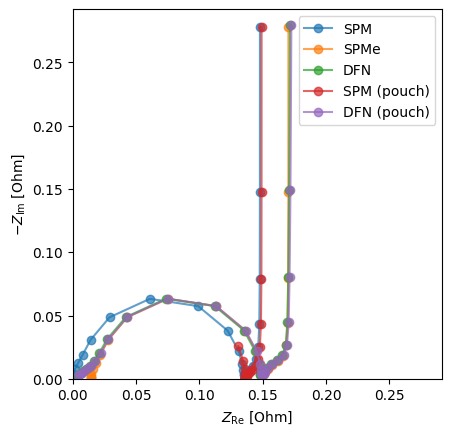

In [4]:
# Load models and parameters
models = [
    pybamm.lithium_ion.SPM(
        options={
            "surface form": "differential",
        },
        name="SPM",
    ),
    pybamm.lithium_ion.SPMe(options={"surface form": "differential"}, name="SPMe"),
    pybamm.lithium_ion.DFN(options={"surface form": "differential"}, name="DFN"),
    pybamm.lithium_ion.SPM(
        {
            "surface form": "differential",
            "current collector": "potential pair",
            "dimensionality": 2,
        },
        name="SPM (pouch)",
    ),
    pybamm.lithium_ion.DFN(
        {
            "surface form": "differential",
            "current collector": "potential pair",
            "dimensionality": 2,
        },
        name="DFN (pouch)",
    ),
]
parameter_values = pybamm.ParameterValues("Marquis2019")
parameter_values = pybamm.get_size_distribution_parameters(
    parameter_values, sd_n=0.2, sd_p=0.4
)

# Loop over models and calculate impedance
frequencies = np.logspace(-4, 4, 30)
impedances = []
for model in models:
    print(f"Start calculating impedance for {model.name}")
    eis_sim = pybammeis.EISSimulation(model, parameter_values=parameter_values)
    impedances_freq = eis_sim.solve(
        frequencies,
    )
    print(f"Finished calculating impedance for {model.name}")
    print(
        "Number of states: ",
        eis_sim.y0.shape[0],
        "Set-up time: ",
        eis_sim.set_up_time,
        "Solve time: ",
        eis_sim.solve_time,
    )
    impedances.append(impedances_freq)

# Compare
_, ax = plt.subplots()
for i, model in enumerate(models):
    ax = pybammeis.nyquist_plot(
        impedances[i], ax=ax, linestyle="-", label=f"{model.name}", alpha=0.7
    )
ax.legend()
plt.show()

Parameters

Man kan bruke parameter_values.update({})! Se pybamm-eis/examples/parameter_sweep for instruksjon

- parameter_values.update for å oppdatere parameteren 
- her kan man også ha en "parameter input" funksjon i solver --> for å sette inn den oppdaterte parameteren 
- SOC kan også være en parameter input i solver! Her har modellen en funksjon som heter "get_min_max_stoiciometries" som avhenger av parametrene dine.  

Kommentar: tror denne input-funksjonen er veldig relevant for oppgaven - her kan jeg lage funksjonen på forhånd og bare pjåte de optimiserte parametrene rett inn, evt tilpasse parameterne til å få best mulig EIS! 

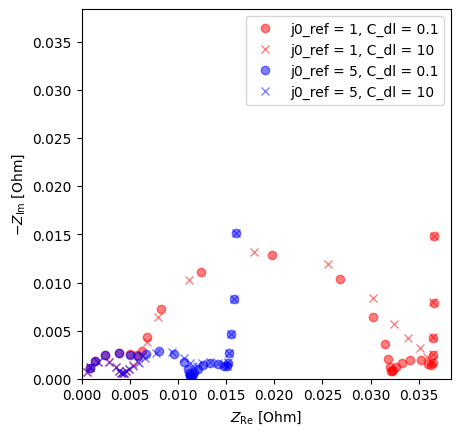

In [5]:

# Load model
model = pybamm.lithium_ion.DFN(
    options={"working electrode": "positive", "surface form": "differential"}
)

# Load parameters
parameter_values = pybamm.ParameterValues("OKane2022_graphite_SiOx_halfcell")


def j0(c_e, c_s_surf, c_s_max, T):
    j0_ref = pybamm.Parameter(
        "Positive electrode reference exchange-current density [A.m-2]"
    )
    c_e_init = pybamm.Parameter("Initial concentration in electrolyte [mol.m-3]")

    return (
        j0_ref
        * (c_e / c_e_init) ** 0.5
        * (c_s_surf / c_s_max) ** 0.5
        * (1 - c_s_surf / c_s_max) ** 0.5
    )


parameter_values.update(
    {
        "Positive electrode reference exchange-current density [A.m-2]": pybamm.InputParameter(
            "j0_ref"
        ),
        "Positive electrode exchange-current density [A.m-2]": j0,
        "Positive electrode double-layer capacity [F.m-2]": pybamm.InputParameter(
            "C_dl"
        ),
    },
    check_already_exists=False,
)

# Create simulation
eis_sim = pybammeis.EISSimulation(model, parameter_values=parameter_values)

# Choose frequencies and calculate impedance, looping over input parameter values
# and adding the results to a Nyquist plot
frequencies = np.logspace(-4, 4, 30)

j0_refs = [1, 5]
C_dls = [0.1, 10]
markers = ["o", "x"]
colors = ["r", "b"]

_, ax = plt.subplots()
for i, j0_ref in enumerate(j0_refs):
    for j, C_dl in enumerate(C_dls):
        eis_sim.solve(frequencies, inputs={"j0_ref": j0_ref, "C_dl": C_dl})
        eis_sim.nyquist_plot(
            ax=ax,
            marker=markers[j],
            color=colors[i],
            alpha=0.5,
            label=f"j0_ref = {j0_ref}, C_dl = {C_dl}",
        )
ax.legend()
plt.show()

# Kommentar: vet ikke hvor c_e, c_s_surf eller c_s_max kommer fra i j_0 funksjonen
# Men tror at disse avhenger av input-parameteren C_dl? 

Her er:
- j0_ref = "Positive electrode reference exchange-current density [A.m-2]
- C_dls = "Positive electrode double-layer capacity [F.m-2]

State of Charge (SOC)

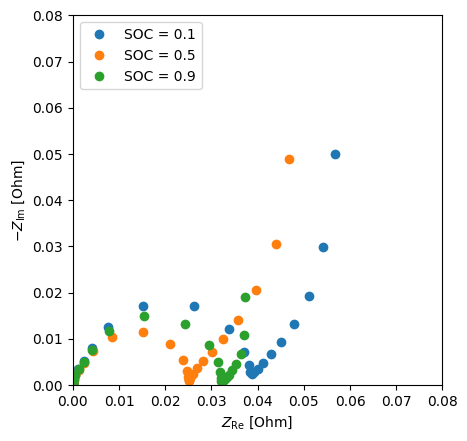

In [6]:
# Load model
model = pybamm.lithium_ion.SPM(options={"surface form": "differential"})

# Set up parameters with cell SOC as an input parameter
parameter_values = pybamm.ParameterValues("Chen2020")

x0, x100, y100, y0 = pybamm.lithium_ion.get_min_max_stoichiometries(parameter_values)
z = pybamm.InputParameter("SOC")
x = x0 + z * (x100 - x0)
y = y0 - z * (y0 - y100)
c_n_max = parameter_values["Maximum concentration in negative electrode [mol.m-3]"]
c_p_max = parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": x * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": y * c_p_max,
    }
)

# Create simulation
eis_sim = pybammeis.EISSimulation(model, parameter_values=parameter_values)

# Choose frequencies and calculate impedance, looping over input parameter values
# and adding the results to a Nyquist plot
frequencies = np.logspace(-4, 4, 30)
_, ax = plt.subplots()
for z in [0.1, 0.5, 0.9]:
    eis_sim.solve(frequencies, inputs={"SOC": z})
    eis_sim.nyquist_plot(ax=ax, label=f"SOC = {z}")
ax.set_xlim([0, 0.08])
ax.set_ylim([0, 0.08])
ax.legend()
plt.show()

Bygge sin egen modell

Man kan også bygge og kjøre EIS simuleringer (med en frequency domain approach) fra bunnen av ved å bruke pybamm og definere en rekke funksjoner. Vet ikke hvor viktig/relevant dette er for oppgaven ettersom den eksisterende pybammeis virker tilstrekkelig nok for vårt formål. I så fall, hvis jeg skal bygge modellen fra bunnen av, trenger jeg nok hjelp til å forstå meg på koden:) Ligger under pybamm-eis/pybammeis/eis_simulation.py. Jeg har likevel notert meg et par "calls" de bruker for å definere ulike funksjoner: 

- pybamm.BaseModel
- pybamm.Geometry
- pybamm.FiniteVolume
- pybamm.Timer()
- pybamm.logger.info
- sim.build()
- pybamm.Variable 
- pybammeis.SymbolReplacer
- pybamm.FunctionParameter
- pybamm.BaseSolver()

Jeg kan jo prøve å definere en "Bode plot" funskjon da. 

Bicgstab - iterativ metode i numerisk linear algebra (antar at vi har så små frekvenser at current vs voltage er pseudo-lineær.)

Prebicgstab - bruker "preconditioned" bicgstab method - betinger et problem til en form som er mer egnet for numeriske løsningsmetoder. 

Nyquist plot - står hvordan denne funksjonen er laget i pybamm-eis/pybammeis/plotting.py - kanskje lage en tilsvarende funksjon for Bode plot? 

Test simulation - her kan man teste simuleringsmetoden sin! Har ikke prøvd ennå. 
- (Kan også teste utilities - se pybamm-eis/tests/test_utils.py)

In [7]:
def test_compare_methods():
    # Set up
    model = pybamm.lithium_ion.SPM(options={"surface form": "differential"}, name="SPM")
    parameter_values = pybamm.ParameterValues("Marquis2019")
    frequencies = np.logspace(-4, 2, 30)

    # Time domain
    I_app = 50 * 1e-3
    number_of_periods = 20
    samples_per_period = 16

    def current_function(t):
        return I_app * pybamm.sin(
            2 * np.pi * pybamm.InputParameter("Frequency [Hz]") * t
        )

    parameter_values["Current function [A]"] = current_function

    sim = pybamm.Simulation(
        model, parameter_values=parameter_values, solver=pybamm.ScipySolver()
    )

    impedances_time = []
    for frequency in frequencies:
        # Solve
        period = 1 / frequency
        dt = period / samples_per_period
        t_eval = np.array(range(0, 1 + samples_per_period * number_of_periods)) * dt
        sol = sim.solve(t_eval, inputs={"Frequency [Hz]": frequency})
        # Extract final two periods of the solution
        current = sol["Current [A]"].entries[-3 * samples_per_period - 1 :]
        voltage = sol["Voltage [V]"].entries[-3 * samples_per_period - 1 :]
        # FFT
        current_fft = fft(current)
        voltage_fft = fft(voltage)
        # Get index of first harmonic
        idx = np.argmax(np.abs(current_fft))
        impedance = -voltage_fft[idx] / current_fft[idx]
        impedances_time.append(impedance)
    impedances_time = np.array(impedances_time)

    # Frequency domain
    methods = ["direct"]
    impedances_freqs = {}
    for method in methods:
        eis_sim = pybammeis.EISSimulation(model, parameter_values=parameter_values)
        impedances_freq = eis_sim.solve(frequencies, method)
        impedances_freqs[method] = impedances_freq

    for method in methods:
        assert np.allclose(
            impedances_time.real, impedances_freqs[method].real, rtol=1e-1
        )
        assert np.allclose(
            impedances_time.imag, impedances_freqs[method].imag, rtol=1e-1
        )


def test_solve_with_inputs():
    model = pybamm.lithium_ion.DFN(
        options={"working electrode": "positive", "surface form": "differential"}
    )
    parameter_values = pybamm.ParameterValues("OKane2022_graphite_SiOx_halfcell")
    parameter_values.update(
        {
            "Positive electrode double-layer capacity [F.m-2]": pybamm.InputParameter(
                "C_dl"
            ),
        },
    )
    eis_sim = pybammeis.EISSimulation(model, parameter_values=parameter_values)
    frequencies = np.logspace(-4, 4, 30)
    eis_sim.solve(frequencies, inputs={"C_dl": 0.1})


def test_bad_method():
    model = pybamm.lithium_ion.DFN(options={"surface form": "differential"})
    eis_sim = pybammeis.EISSimulation(model)
    frequencies = np.logspace(-4, 4, 30)
    with pytest.raises(ValueError, match="'method' must be"):
        eis_sim.solve(frequencies, method="bad_method")